In [1]:
%pylab inline
import pickle

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.getpid()

73096

In [4]:
from gears import PertData, GEARS

/opt/conda/envs/gnew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
pert_data = PertData('/nfs_beijing/minsheng/scbig/bioinfoDownStream/gears_singlecell/data/')

Found local copy...


read /nfs_beijing/minsheng/scbig/bioinfoDownStream/gears_singlecell/data/gene2go_all.pkl


In [6]:
from os.path import join as pjoin
pert_data.load(data_path = pjoin('/nfs_beijing/minsheng/scbig/bioinfoDownStream/gears_singlecell/data/', 'gse133344_k562gi_oe_pert227_84986_19264_withtotalcount'))

These perturbations are not in the GO graph and is thus not able to make prediction for...
['LYL1+IER5L' 'IER5L+ctrl']
Local copy of pyg dataset is detected. Loading...
Done!


In [7]:
pert_data.prepare_split(split = 'simulation', seed = 1, train_gene_set_size=0.75)
pert_data.get_dataloader(batch_size = 6, test_batch_size = 6)

Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:10
combo_seen1:60
combo_seen2:14
unseen_single:25
Done!
Creating dataloaders....
Done!


In [8]:
gears_model = GEARS(pert_data, device = 'cuda:1')

In [9]:
modelPath = '/nfs_beijing/minsheng/scbig/bioinfoDownStream/gears_singlecell/results/gse133344_k562gi_oe_pert227_84986_19264_withtotalcount/0.75/split_simulation_seed_1_hidden_128_epochs_15_batch_30/2023-03-21_20-58-58'

In [11]:
gears_model.load_pretrained(modelPath)

Use accumulation steps: 1
Use mode: v1
Use higres: 0
No Single cell model load!


In [11]:
pretrain_model = GEARS(pert_data, device = 'cuda:1')
modelPath = '/nfs_beijing/minsheng/scbig/bioinfoDownStream/gears_singlecell/results/gse133344_k562gi_oe_pert227_84986_19264_withtotalcount/0.75/50m-0.1B_split_simulation_seed_1_hidden_512_bin_autobin_resolution_append_singlecell_maeautobin_finetune_frozen_epochs_15_batch_6_accmu_5_mode_v1_highres_0_lr_0.01/2023-03-27_15-46-01/'
pretrain_model.load_pretrained(modelPath)

Use accumulation steps: 5
Use mode: v1
Use higres: 0
Single cell model load success! model type: MAEAutobin


In [12]:
pert_data.subgroup['test_subgroup'].keys()

dict_keys(['combo_seen0', 'combo_seen1', 'combo_seen2', 'unseen_single'])

In [13]:
pert_data.adata.obs.condition.unique()

['TSC22D1+ctrl', 'KLF1+MAP2K6', 'ctrl', 'CEBPE+RUNX1T1', 'MAML2+ctrl', ..., 'SNAI1+DLX2', 'IGDCC3+PRTG', 'CDKN1C+ctrl', 'HES7+ctrl', 'CDKN1B+CDKN1A']
Length: 225
Categories (225, object): ['AHR+FEV', 'AHR+KLF1', 'AHR+ctrl', 'ARID1A+ctrl', ..., 'ZC3HAV1+ctrl', 'ZNF318+FOXL2', 'ZNF318+ctrl', 'ctrl']

In [14]:
test_single = pert_data.subgroup['test_subgroup']['unseen_single']

In [15]:
query = test_single[0]

In [16]:
adata = gears_model.adata
gene2idx = gears_model.node_map
cond2name = dict(adata.obs[['condition', 'condition_name']].values)
gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))
de_idx = [gene2idx[gene_raw2id[i]] for i in adata.uns['top_non_dropout_de_20'][cond2name[query]]]

In [18]:
from gears.inference import evaluate, compute_metrics, deeper_analysis, non_dropout_analysis, compute_synergy_loss,GI_subgroup

In [65]:
test_res = evaluate(gears_model.dataloader['test_loader'], gears_model.best_model, gears_model.config['uncertainty'], gears_model.device)   
test_metrics, test_pert_res = compute_metrics(test_res) 

In [259]:
test_metrics

{'mse': 0.0031829667,
 'mse_de': 0.23347622,
 'pearson': 0.9905523569389885,
 'pearson_de': 0.7692721177399929}

In [ ]:
test_res_pt = evaluate(pretrain_model.dataloader['test_loader'], pretrain_model.best_model, pretrain_model.config['uncertainty'], pretrain_model.device)   
test_metrics_pt, test_pert_res_pt = compute_metrics(test_res_pt) 

In [ ]:
import pickle
with open('Norman_results/baseline_testpred.pkl','wb') as f:
    pickle.dump([test_res,test_metrics,test_pert_res],f)
with open('Norman_results/scFoundation_testpred.pkl','wb') as f:
    pickle.dump([test_res_pt,test_metrics_pt,test_pert_res_pt],f)

In [26]:
import pickle
with open('Norman_results/baseline_testpred.pkl','rb') as f:
    [test_res,test_metrics,test_pert_res] = pickle.load(f)
with open('Norman_results/scFoundation_testpred.pkl','rb') as f:
    [test_res_pt,test_metrics_pt,test_pert_res_pt] = pickle.load(f)

In [27]:
test_metrics_pt

{'mse': 0.008688236,
 'mse_de': 0.18268527,
 'pearson': 0.9764763817910606,
 'pearson_de': 0.7924526672353088}

In [28]:
import pandas as pd
testptdf = pd.DataFrame(test_pert_res_pt)
testdf = pd.DataFrame(test_pert_res)
testptdf['type']=testptdf.index
testdf['type']=testdf.index
pltdf1 = testptdf.melt(id_vars='type')
pltdf2 = testdf.melt(id_vars='type')
pltdf1['model']='scFoundation'
pltdf2['model']='Baseline'
pltdf = pd.concat([pltdf1,pltdf2])

In [29]:
import scanpy as sc
import seaborn as sns
import colorbm as cbm
import scipy.stats
sns.set_palette(sns.color_palette(cbm.pal('npg').as_hex))

In [30]:
pltdf['ptype']='Unknown'
pltdf['testtype']='Unknown'

In [38]:
#GIs in the bottom
for k in GIs.keys():
    for n in GIs[k]:
        pltdf.loc[pltdf.variable==n,'ptype']=k

In [32]:
for name, pert_list in pretrain_model.subgroup['test_subgroup'].items():
    for pert in pert_list:
        pltdf.loc[pltdf.variable==pert,'testtype']=name

In [33]:
tmppltdf = pltdf.loc[pltdf.type=='mse_de',['value','testtype','model']]
tmppltdf = tmppltdf.append({'value':test_metrics_pt['mse_de'],'testtype':'all','model':'scFoundation'},ignore_index=True)
tmppltdf = tmppltdf.append({'value':test_metrics['mse_de'],'testtype':'all','model':'Baseline'},ignore_index=True)                                        

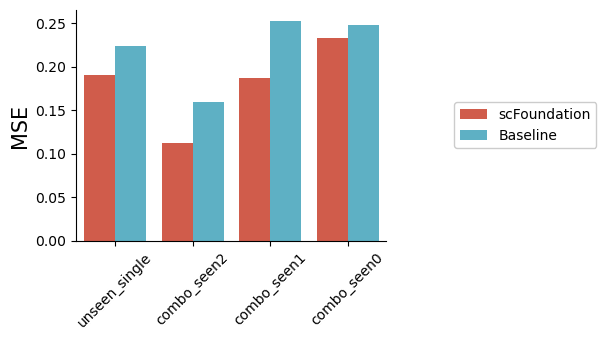

In [34]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,3)
sns.barplot(pltdf[pltdf.type=='mse_de'],y='value',x='testtype',hue='model',errorbar=None,order=['unseen_single', 'combo_seen2', 'combo_seen1', 'combo_seen0'])
plt.xticks(rotation=45,fontsize=10);
plt.ylabel('MSE',fontsize=15)
plt.yticks(fontsize=10)
plt.xlabel(None)

plt.legend(loc='center right',bbox_to_anchor=(1.7, 0.5),facecolor='white', framealpha=1);
# plt.savefig('Norman_MSEall.pdf',bbox_inches='tight')

In [40]:
baseline_out = deeper_analysis(gears_model.adata, test_res)

In [41]:
pretrain_out = deeper_analysis(pretrain_model.adata, test_res_pt)

In [42]:
deepbaseline = pd.DataFrame(baseline_out)
deepscFoundation = pd.DataFrame(pretrain_out)

In [43]:
deepbaseline.to_csv('Norman_results/deepbaseline.csv')
deepscFoundation.to_csv('Norman_results/deepbaseline.csv')

In [44]:
deepbaseline['type']=deepbaseline.index
deepscFoundation['type']=deepscFoundation.index
pltdf1 = deepbaseline.melt(id_vars='type')
pltdf2 = deepscFoundation.melt(id_vars='type')
pltdf1['model']='Baseline'
pltdf2['model']='scFoundation'
pltdf = pd.concat([pltdf2,pltdf1])

In [45]:
pltdf['ptype']='Unknown'
pltdf['testtype']='Unknown'

In [46]:
for k in GIs.keys():
    for n in GIs[k]:
        pltdf.loc[pltdf.variable==n,'ptype']=k

for name, pert_list in pretrain_model.subgroup['test_subgroup'].items():
    for pert in pert_list:
        pltdf.loc[pltdf.variable==pert,'testtype']=name

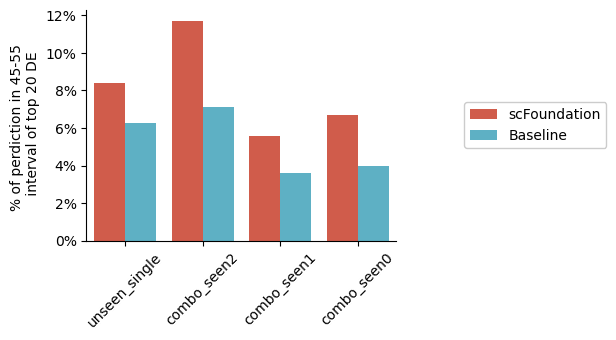

In [47]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,3)
ax=sns.barplot(pltdf[pltdf.type=='frac_in_range_45_55'],y='value',x='testtype',hue='model',errorbar=None,order=['unseen_single', 'combo_seen2', 'combo_seen1', 'combo_seen0'])
# sns.boxplot(pltdf[pltdf.type=='mse_de'],y='value',x='testtype',hue='model',order=['unseen_single', 'combo_seen2', 'combo_seen1', 'combo_seen0'])
plt.xticks(rotation=45,fontsize=10);
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.ylabel('% of perdiction in 45-55 \n interval of top 20 DE',fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(None)
# plt.ylim(0.6,1)

plt.legend(loc='center right',bbox_to_anchor=(1.7, 0.5),facecolor='white', framealpha=1);
# plt.savefig('Norman_Frac4555.pdf',bbox_inches='tight')


## GI

In [48]:
all2pertb = [x.split('+') for x in deepbaseline.columns.tolist()[:-1] if x.split('+')[1]!='ctrl']

### pred GI

In [56]:
basegi=[]
for p2 in all2pertb:
    tmpgi = gears_model.GI_predict(p2)
    basegi.append(tmpgi)

In [57]:
with open('Norman_results/basegi.pkl','wb') as f:
    pickle.dump(basegi,f)

In [58]:
basegiscore = {}
for i in range(len(all2pertb)):
    p2 = all2pertb[i]
    dfdict = {}
    for key in basegi[i].keys():
        if key=='ts':
            continue
        dfdict[key]=basegi[i][key]
    basegiscore[p2[0]+'+'+p2[1]]=dfdict

In [60]:
pretraingi=[]
for p2 in all2pertb:
    tmpgi = pretrain_model.GI_predict(p2)
    pretraingi.append(tmpgi)
    
with open('Norman_results/pretraingi.pkl','wb') as f:
    pickle.dump(pretraingi,f)

In [61]:
pretgiscore = {}
for i in range(len(all2pertb)):
    p2 = all2pertb[i]
    dfdict = {}
    for key in pretraingi[i].keys():
        if key=='ts':
            continue
        dfdict[key]=pretraingi[i][key]
    pretgiscore[p2[0]+'+'+p2[1]]=dfdict

### truth GI

In [62]:
from gears.utils import get_mean_control,get_GI_genes_idx,get_GI_params
def GI_truth(model, combo, GI_genes_file='./genes_with_hi_mean.npy'):
    ## given a gene pair, return (1) transcriptome of A,B,A+B and (2) GI scores. 
    ## if uncertainty mode is on, also return uncertainty score.
    
    pred = {}
    pred[combo[0]] = np.array(gears_model.adata[gears_model.adata.obs.condition==combo[0]+'+ctrl'].X.mean(0))[0]
    pred[combo[1]] = np.array(gears_model.adata[gears_model.adata.obs.condition==combo[1]+'+ctrl'].X.mean(0))[0]
    pred['_'.join(combo)] = np.array(gears_model.adata[gears_model.adata.obs.condition=='+'.join(combo)].X.mean(0))[0]
    
    mean_control = get_mean_control(model.adata).values  
    pred = {p:pred[p]-mean_control for p in pred} 

    if GI_genes_file is not None:
        # If focussing on a specific subset of genes for calculating metrics
        GI_genes_idx = get_GI_genes_idx(model.adata, GI_genes_file)       
    else:
        GI_genes_idx = np.arange(len(model.adata.var.gene_name.values))
    pred = {p:pred[p][GI_genes_idx] for p in pred}
    return get_GI_params(pred, combo)

In [63]:
from tqdm import tqdm
truthgi=[]
for p2 in tqdm(all2pertb):
    tmpgi = GI_truth(gears_model,p2)
    truthgi.append(tmpgi)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [11:03<00:00,  7.90s/it]


In [64]:
with open('Norman_results/truthgi.pkl','wb') as f:
    pickle.dump(truthgi,f)

In [65]:
truthgiscore = {}
for i in range(len(all2pertb)):
    p2 = all2pertb[i]
    dfdict = {}
    for key in truthgi[i].keys():
        if key=='ts':
            continue
        dfdict[key]=truthgi[i][key]
    truthgiscore[p2[0]+'+'+p2[1]]=dfdict

### preprocess

In [109]:
basegidf = pd.DataFrame(basegiscore)
basegidf['metric']=basegidf.index
pretgidf = pd.DataFrame(pretgiscore)
pretgidf['metric']=pretgidf.index
truthgidf = pd.DataFrame(truthgiscore)
truthgidf['metric']=truthgidf.index


pltdf1 = basegidf.melt(id_vars='metric')
pltdf2 = pretgidf.melt(id_vars='metric')
pltdf3 = truthgidf.melt(id_vars='metric')
pltdf1['model']='Baseline'
pltdf2['model']='scFoundation'
pltdf3['model']='GT'

pltdf = pd.concat([pltdf2,pltdf1,pltdf3])

pltdf['ptype']='Unknown'
pltdf['testtype']='Unknown'

for k in GIs.keys():
    for n in GIs[k]:
        pltdf.loc[pltdf.variable==n,'ptype']=k

for name, pert_list in pretrain_model.subgroup['test_subgroup'].items():
    for pert in pert_list:
        pltdf.loc[pltdf.variable==pert,'testtype']=name

## Evaluation GI

### Allpearson

In [68]:
from scipy.stats import pearsonr

PearsonRResult(statistic=0.18373826311680785, pvalue=0.0943209138947755)


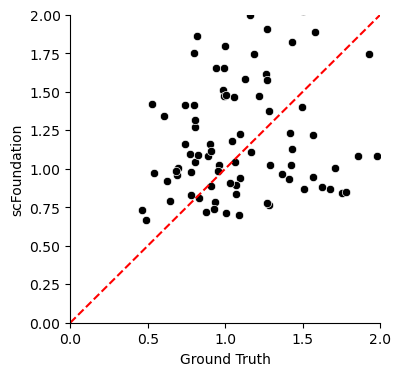

In [69]:
tmpdf1 = pltdf[(pltdf.model=='GT')&(pltdf.metric=='mag')].copy()
tmpdf1.index=tmpdf1.variable
tmpdf2 = pltdf[(pltdf.model=='scFoundation')&(pltdf.metric=='mag')].copy()
tmpdf2.index=tmpdf2.variable
assert tmpdf1.index.tolist()==tmpdf2.index.tolist()
figsize(4,4)
sns.scatterplot(x=tmpdf1.value,y=tmpdf2.value,color='black');
print(pearsonr(tmpdf1.value,tmpdf2.value))
plt.xlim(0,2)
plt.ylim(0,2)
plt.xlabel('Ground Truth')
plt.ylabel('scFoundation')
sns.lineplot(x=[0,2],y=[0,2],color='red',linestyle='--');
# plt.savefig(f'Pearson_mag_pretrain.pdf',bbox_inches='tight')

PearsonRResult(statistic=0.08810784775331863, pvalue=0.4254663553097158)


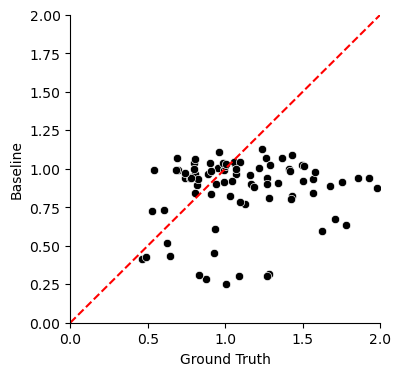

In [70]:
tmpdf1 = pltdf[(pltdf.model=='GT')&(pltdf.metric=='mag')].copy()
tmpdf1.index=tmpdf1.variable
tmpdf2 = pltdf[(pltdf.model=='Baseline')&(pltdf.metric=='mag')].copy()
tmpdf2.index=tmpdf2.variable
assert tmpdf1.index.tolist()==tmpdf2.index.tolist()
sns.scatterplot(x=tmpdf1.value,y=tmpdf2.value,color='black');
print(pearsonr(tmpdf1.value,tmpdf2.value))
plt.xlim(0,2)
plt.ylim(0,2)
plt.xlabel('Ground Truth')
plt.ylabel('Baseline')
sns.lineplot(x=[0,2],y=[0,2],color='red',linestyle='--');
# plt.savefig(f'Pearson_mag_baseline.pdf',bbox_inches='tight')

### AUROC

In [110]:
pltdf = pltdf[pltdf.ptype!='Unknown']

In [111]:
pltdf

,metric,variable,value,model,ptype,testtype
0,c1,AHR+FEV,1.215298,scFoundation,SYNERGY,combo_seen1
1,c2,AHR+FEV,-0.041840,scFoundation,SYNERGY,combo_seen1
2,mag,AHR+FEV,1.216018,scFoundation,SYNERGY,combo_seen1
3,dcor,AHR+FEV,0.989761,scFoundation,SYNERGY,combo_seen1
4,dcor_singles,AHR+FEV,0.994908,scFoundation,SYNERGY,combo_seen1
...,...,...,...,...,...,...
835,dcor_first,ZC3HAV1+CEBPE,0.436643,GT,NEOMORPHIC,combo_seen2
836,dcor_second,ZC3HAV1+CEBPE,0.423572,GT,NEOMORPHIC,combo_seen2
837,corr_fit,ZC3HAV1+CEBPE,0.812783,GT,NEOMORPHIC,combo_seen2
838,dominance,ZC3HAV1+CEBPE,0.545474,GT,NEOMORPHIC,combo_seen2


In [125]:
aucdf = pltdf[(pltdf.metric=='mag')]
aucdf['label']=0
aucdf.loc[aucdf.ptype=='SYNERGY','label']=1

import numpy as np
from sklearn import metrics
t1=aucdf.loc[aucdf.model=='scFoundation']
t1 = t1.sort_values('value',ascending=False)
t2=aucdf.loc[aucdf.model=='Baseline']
t2 = t2.sort_values('value',ascending=False)
pfpr, ptpr, thresholds = metrics.roc_curve(t1['label'],t1['value'], pos_label=1)
bfpr, btpr, thresholds = metrics.roc_curve(t2['label'],t2['value'], pos_label=1)
N=20
print(aucdf.label.sum(),sum(t1.label.tolist()[:N]),sum(t2.label.tolist()[:N]))

60 7 5


In [126]:
from matplotlib_venn import venn3,venn3_circles

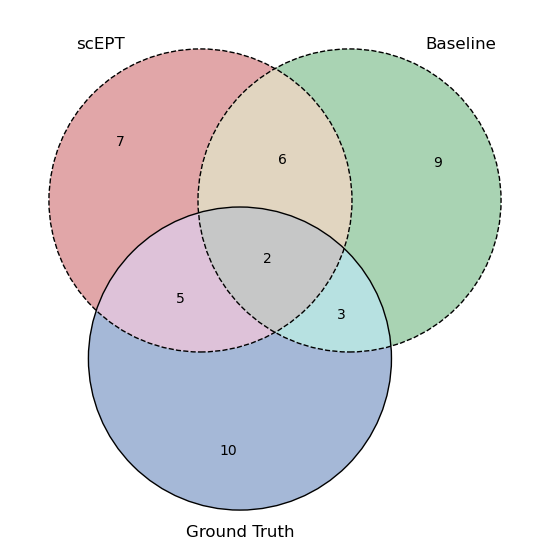

In [127]:
gtset = set(aucdf[aucdf.ptype=='SYNERGY'].variable.tolist())
figsize(7,7)

venn3(subsets=[set(t1.variable.tolist()[:N]),set(t2.variable.tolist()[:N]),gtset],
     set_labels=['scEPT','Baseline','Ground Truth'],
     set_colors=('#C44E52','#55A868','#4C72B0'),
     alpha=0.5)

c=venn3_circles(subsets =[set(t1.variable.tolist()[:N]),set(t2.variable.tolist()[:N]),gtset], linestyle='--', linewidth=1, color="black")
c[2].set_ls('-')
# plt.savefig(f'Venn_SYNERGY.pdf',bbox_inches='tight')

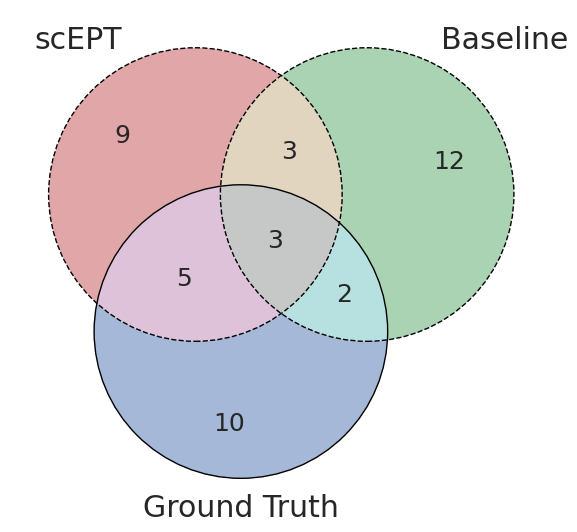

In [1603]:
gtset = set(aucdf[aucdf.ptype=='SYNERGY'].variable.tolist())
figsize(7,7)

venn3(subsets=[set(t1.variable.tolist()[:N]),set(t2.variable.tolist()[:N]),gtset],
     set_colors=('#C44E52','#55A868','#4C72B0'),
     # set_colors=cbm.pal('npg').as_hex,
     alpha=0.5)

c=venn3_circles(subsets =[set(t1.variable.tolist()[:N]),set(t2.variable.tolist()[:N]),gtset], linestyle='--', linewidth=1, color="black")
c[2].set_ls('-')
# plt.savefig(f'Venn_SYNERGY.pdf',bbox_inches='tight')

In [119]:
aucdf = pltdf[(pltdf.metric=='mag')]
aucdf['label']=0
aucdf.loc[aucdf.ptype=='SUPPRESSOR','label']=1
print(aucdf.label.sum())
import numpy as np
from sklearn import metrics
t1=aucdf.loc[aucdf.model=='scFoundation']
t1 = t1.sort_values('value',ascending=True)
t2=aucdf.loc[aucdf.model=='Baseline']
t2 = t2.sort_values('value',ascending=True)
pfpr, ptpr, thresholds = metrics.roc_curve(t1['label'],-t1['value'], pos_label=1)
bfpr, btpr, thresholds = metrics.roc_curve(t2['label'],-t2['value'], pos_label=1)
N=20
print(sum(t1.label.tolist()[:N]),sum(t2.label.tolist()[:N]))

30
3 1


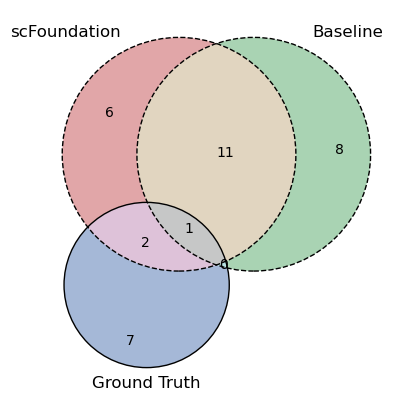

In [124]:
sns.set_palette(sns.color_palette("deep", desat=0.75))
gtset = set(aucdf[aucdf.ptype=='SUPPRESSOR'].variable.tolist())
figsize(5,5)
venn=venn3(subsets=[set(t1.variable.tolist()[:N]),set(t2.variable.tolist()[:N]),gtset],
     set_labels=['scFoundation','Baseline','Ground Truth'],
     set_colors=('#C44E52','#55A868','#4C72B0'),
     alpha=.5)
c=venn3_circles(subsets =[set(t1.variable.tolist()[:N]),set(t2.variable.tolist()[:N]),gtset], linestyle='--', linewidth=1, color="black")
c[2].set_ls('-')
# plt.savefig(f'Venn_SUPPRESSOR.pdf',bbox_inches='tight')

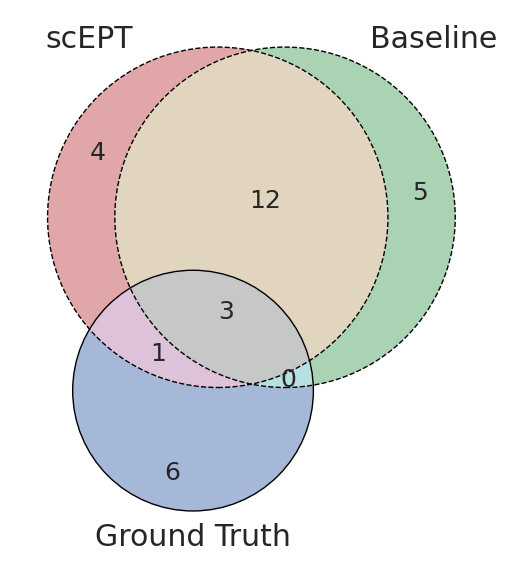

In [1591]:
#different random seed from different computational nodes
gtset = set(aucdf[aucdf.ptype=='SUPPRESSOR'].variable.tolist())
figsize(7,7)
venn3(subsets=[set(t1.variable.tolist()[:N]),set(t2.variable.tolist()[:N]),gtset],
     set_labels=['scFoundation','Baseline','Ground Truth'],
     set_colors=('#C44E52','#55A868','#4C72B0'),
     alpha=.5)
c=venn3_circles(subsets =[set(t1.variable.tolist()[:N]),set(t2.variable.tolist()[:N]),gtset], linestyle='--', linewidth=1, color="black")
c[2].set_ls('-')
# plt.savefig(f'Venn_SUPPRESSOR.pdf',bbox_inches='tight')

## Case

In [128]:
tmpdf1 = pd.DataFrame(test_pert_res)
tmpdf2 = pd.DataFrame(test_pert_res_pt)
tmpdf2.index=['mse2','pearson2','msede','pde']
tmpdf = pd.concat([tmpdf1,tmpdf2],axis=0).T

tmpdf['delta']=tmpdf.msede-tmpdf.mse_de

tmpdf.sort_values('delta',ascending=True)

,mse,pearson,mse_de,pearson_de,mse2,pearson2,msede,pde,delta
ETS2+CEBPE,0.002935,0.989295,1.010791,0.373121,0.013505,0.962359,0.213089,0.864452,-0.797702
CEBPE+RUNX1T1,0.001556,0.994375,0.580853,0.687132,0.012950,0.964579,0.139862,0.925210,-0.440991
ETS2+MAPK1,0.003726,0.986880,0.835079,0.674123,0.007862,0.978583,0.406497,0.844448,-0.428582
CEBPE+SPI1,0.008479,0.968997,0.462792,0.441697,0.017049,0.954097,0.166750,0.923636,-0.296042
FOSB+OSR2,0.002805,0.989964,0.589350,0.751351,0.006757,0.981116,0.298763,0.861768,-0.290587
...,...,...,...,...,...,...,...,...,...
SAMD1+PTPN12,0.001484,0.994966,0.122989,0.975204,0.009130,0.976364,0.159649,0.968008,0.036660
JUN+CEBPB,0.006102,0.977231,0.025936,0.000000,0.011569,0.967546,0.063379,0.000000,0.037443
CEBPB+CEBPA,0.008631,0.968021,0.005232,0.000000,0.013110,0.960999,0.042772,0.000000,0.037540
JUN+CEBPA,0.010539,0.960125,0.014122,0.000000,0.016631,0.950753,0.062519,0.000000,0.048396


In [129]:
query='ETS2+CEBPE'
adata = gears_model.adata
gene2idx = gears_model.node_map
cond2name = dict(adata.obs[['condition', 'condition_name']].values)
gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))
de_idx = [gene2idx[gene_raw2id[i]] for i in adata.uns['top_non_dropout_de_20'][cond2name[query]]]
genes = [gene_raw2id[i] for i in adata.uns['top_non_dropout_de_20'][cond2name[query]]]

In [130]:
p_idx = np.where(test_res_pt['pert_cat'] == query)[0]
scFoundationpred=pd.DataFrame(test_res_pt['pred'][p_idx][:,de_idx],columns=genes)
p_idx = np.where(test_res['pert_cat'] == query)[0]
baselinepred=pd.DataFrame(test_res['pred'][p_idx][:,de_idx],columns=genes)

In [131]:
truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]
ctrl_means = adata[adata.obs['condition'] == 'ctrl'].to_df().mean()[de_idx].values
scFoundationpred = scFoundationpred - ctrl_means
baselinepred = baselinepred - ctrl_means
truth = truth - ctrl_means

In [132]:
pltdf1= scFoundationpred.melt()
pltdf2= baselinepred.melt()

pltdf3 = pd.DataFrame(truth,columns=genes).melt()
pltdf1['model']='scFoundation'
pltdf2['model']='Baseline'
pltdf3['model']='GT'
pltdf = pd.concat([pltdf1,pltdf2,pltdf3])

Text(0.5, 1.0, 'ETS2+CEBPE')

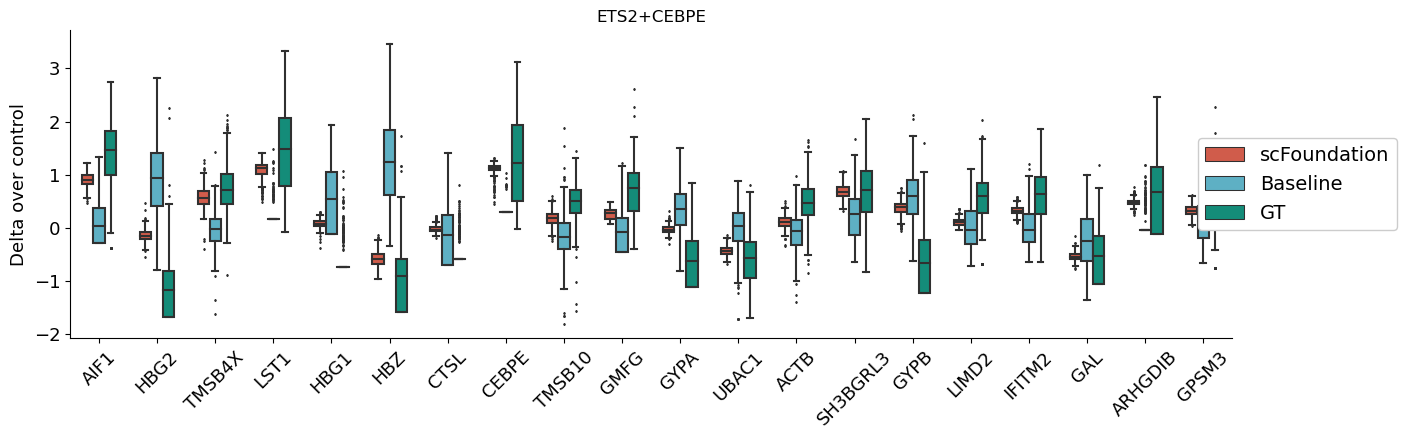

In [134]:
sns.set_palette(sns.color_palette(cbm.pal('npg').as_hex))
figsize(15,4)
sns.boxplot(data=pltdf,x='variable',y='value',hue='model',hue_order=['scFoundation','Baseline','GT',],fliersize=1,width=0.6)
plt.legend(loc='center right',bbox_to_anchor=(1.15, 0.5),facecolor='white', framealpha=1,fontsize=14);
plt.xticks(rotation=45,fontsize=13);
plt.ylabel('Delta over control',fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel(None);
plt.title(query)
# plt.savefig('ETS2+CEBPE.pdf',bbox_inches='tight')

## content

In [36]:
GIs = {
    'NEOMORPHIC': ['CBL+TGFBR2',
                  'KLF1+TGFBR2',
                  'MAP2K6+SPI1',
                  'SAMD1+TGFBR2',
                  'TGFBR2+C19orf26',
                  'TGFBR2+ETS2',
                  'CBL+UBASH3A',
                  'CEBPE+KLF1',
                  'DUSP9+MAPK1',
                  'FOSB+PTPN12',
                  'PLK4+STIL',
                  'PTPN12+OSR2',
                  'ZC3HAV1+CEBPE'],
    'ADDITIVE': ['BPGM+SAMD1',
                'CEBPB+MAPK1',
                'CEBPB+OSR2',
                'DUSP9+PRTG',
                'FOSB+OSR2',
                'IRF1+SET',
                'MAP2K3+ELMSAN1',
                'MAP2K6+ELMSAN1',
                'POU3F2+FOXL2',
                'RHOXF2BB+SET',
                'SAMD1+PTPN12',
                'SAMD1+UBASH3B',
                'SAMD1+ZBTB1',
                'SGK1+TBX2',
                'TBX3+TBX2',
                'ZBTB10+SNAI1'],
    'EPISTASIS': ['AHR+KLF1',
                 'MAPK1+TGFBR2',
                 'TGFBR2+IGDCC3',
                 'TGFBR2+PRTG',
                 'UBASH3B+OSR2',
                 'DUSP9+ETS2',
                 'KLF1+CEBPA',
                 'MAP2K6+IKZF3',
                 'ZC3HAV1+CEBPA'],
    'REDUNDANT': ['CDKN1C+CDKN1A',
                 'MAP2K3+MAP2K6',
                 'CEBPB+CEBPA',
                 'CEBPE+CEBPA',
                 'CEBPE+SPI1',
                 'ETS2+MAPK1',
                 'FOSB+CEBPE',
                 'FOXA3+FOXA1'],
    'SYNERGY': ['CNN1+UBASH3A',
                    'ETS2+MAP7D1',
                    'FEV+CBFA2T3',
                    'FEV+ISL2',
                    'FEV+MAP7D1',
                    'PTPN12+UBASH3A',
                    'CBL+CNN1',
                            'CBL+PTPN12',
                            'CBL+PTPN9',
                            'CBL+UBASH3B',
                            'FOXA3+FOXL2',
                            'FOXA3+HOXB9',
                            'FOXL2+HOXB9',
                            'UBASH3B+CNN1',
                            'UBASH3B+PTPN12',
                            'UBASH3B+PTPN9',
                            'UBASH3B+ZBTB25',
                                'AHR+FEV',
                                'DUSP9+SNAI1',
                                'FOXA1+FOXF1',
                                'FOXA1+FOXL2',
                                'FOXA1+HOXB9',
                                'FOXF1+FOXL2',
                                'FOXF1+HOXB9',
                                'FOXL2+MEIS1',
                                'IGDCC3+ZBTB25',
                                'POU3F2+CBFA2T3',
                                'PTPN12+ZBTB25',
                                'SNAI1+DLX2',
                                'SNAI1+UBASH3B'],
    'SUPPRESSOR': ['CEBPB+PTPN12',
                  'CEBPE+CNN1',
                  'CEBPE+PTPN12',
                  'CNN1+MAPK1',
                  'ETS2+CNN1',
                  'ETS2+IGDCC3',
                  'ETS2+PRTG',
                  'FOSB+UBASH3B',
                  'IGDCC3+MAPK1',
                  'LYL1+CEBPB',
                  'MAPK1+PRTG',
                  'PTPN12+SNAI1']
}

In [37]:
GIs_fine = {
    'NEOMORPHIC': ['CBL+TGFBR2',
                  'KLF1+TGFBR2',
                  'MAP2K6+SPI1',
                  'SAMD1+TGFBR2',
                  'TGFBR2+C19orf26',
                  'TGFBR2+ETS2',
                  'CBL+UBASH3A',
                  'CEBPE+KLF1',
                  'DUSP9+MAPK1',
                  'FOSB+PTPN12',
                  'PLK4+STIL',
                  'PTPN12+OSR2',
                  'ZC3HAV1+CEBPE'],
    'ADDITIVE': ['BPGM+SAMD1',
                'CEBPB+MAPK1',
                'CEBPB+OSR2',
                'DUSP9+PRTG',
                'FOSB+OSR2',
                'IRF1+SET',
                'MAP2K3+ELMSAN1',
                'MAP2K6+ELMSAN1',
                'POU3F2+FOXL2',
                'RHOXF2BB+SET',
                'SAMD1+PTPN12',
                'SAMD1+UBASH3B',
                'SAMD1+ZBTB1',
                'SGK1+TBX2',
                'TBX3+TBX2',
                'ZBTB10+SNAI1'],
    'EPISTASIS': ['AHR+KLF1',
                 'MAPK1+TGFBR2',
                 'TGFBR2+IGDCC3',
                 'TGFBR2+PRTG',
                 'UBASH3B+OSR2',
                 'DUSP9+ETS2',
                 'KLF1+CEBPA',
                 'MAP2K6+IKZF3',
                 'ZC3HAV1+CEBPA'],
    'REDUNDANT': ['CDKN1C+CDKN1A',
                 'MAP2K3+MAP2K6',
                 'CEBPB+CEBPA',
                 'CEBPE+CEBPA',
                 'CEBPE+SPI1',
                 'ETS2+MAPK1',
                 'FOSB+CEBPE',
                 'FOXA3+FOXA1'],
    'POTENTIATION': ['CNN1+UBASH3A',
                    'ETS2+MAP7D1',
                    'FEV+CBFA2T3',
                    'FEV+ISL2',
                    'FEV+MAP7D1',
                    'PTPN12+UBASH3A'],
    'SYNERGY_SIMILAR_PHENO':['CBL+CNN1',
                            'CBL+PTPN12',
                            'CBL+PTPN9',
                            'CBL+UBASH3B',
                            'FOXA3+FOXL2',
                            'FOXA3+HOXB9',
                            'FOXL2+HOXB9',
                            'UBASH3B+CNN1',
                            'UBASH3B+PTPN12',
                            'UBASH3B+PTPN9',
                            'UBASH3B+ZBTB25'],
    'SYNERGY_DISSIMILAR_PHENO': ['AHR+FEV',
                                'DUSP9+SNAI1',
                                'FOXA1+FOXF1',
                                'FOXA1+FOXL2',
                                'FOXA1+HOXB9',
                                'FOXF1+FOXL2',
                                'FOXF1+HOXB9',
                                'FOXL2+MEIS1',
                                'IGDCC3+ZBTB25',
                                'POU3F2+CBFA2T3',
                                'PTPN12+ZBTB25',
                                'SNAI1+DLX2',
                                'SNAI1+UBASH3B'],
    'SUPPRESSOR': ['CEBPB+PTPN12',
                  'CEBPE+CNN1',
                  'CEBPE+PTPN12',
                  'CNN1+MAPK1',
                  'ETS2+CNN1',
                  'ETS2+IGDCC3',
                  'ETS2+PRTG',
                  'FOSB+UBASH3B',
                  'IGDCC3+MAPK1',
                  'LYL1+CEBPB',
                  'MAPK1+PRTG',
                  'PTPN12+SNAI1']
}
